In [1]:
import pandas as pd
import cv2

In [2]:
data_dir = 'Affectnet Dataset'
data=pd.read_csv('Affectnet Dataset\labels.csv')

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\biswa\AppData\Local\Temp\ipykernel_7812\3271766593.py:2: SyntaxWarning: invalid escape sequence '\l'
  data=pd.read_csv('Affectnet Dataset\labels.csv')


In [3]:
data.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [4]:
data.info

<bound method DataFrame.info of        Unnamed: 0                        pth     label    relFCs
0               0     anger/image0000006.jpg  surprise  0.873142
1               1     anger/image0000060.jpg     anger  0.852311
2               2     anger/image0000061.jpg     anger  0.800957
3               3     anger/image0000066.jpg   disgust  0.843079
4               4     anger/image0000106.jpg     anger  0.849108
...           ...                        ...       ...       ...
28170       28170  surprise/image0034960.jpg  surprise  0.825263
28171       28171  surprise/image0034961.jpg  surprise  0.738646
28172       28172  surprise/image0034966.jpg  surprise  0.774524
28173       28173  surprise/image0034973.jpg   neutral  0.766952
28174       28174  surprise/image0042075.jpg   disgust  0.832160

[28175 rows x 4 columns]>

In [5]:
data.iloc[0]['pth']

'anger/image0000006.jpg'

In [6]:
X = data['pth'].values
y = data['label'].values

In [7]:
import cv2
from keras.utils import to_categorical

def crop_face(image_path):
    img = cv2.imread(image_path)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clf = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces = clf.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
    
    if len(faces) == 0:
        return None

    (x, y, w, h) = faces[0]
    
    # Crop the detected face region from the image
    cropped_face = img[y:y+h, x:x+w]
    #print(len(cropped_face))
    return cropped_face


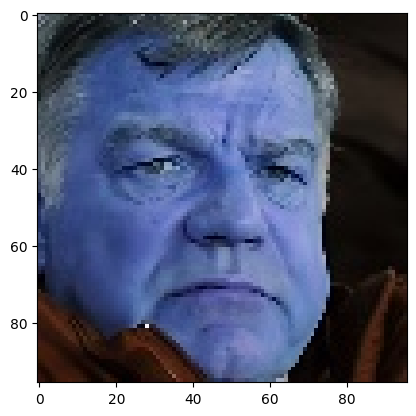

In [8]:
img = cv2.imread("Affectnet Dataset/"+data.iloc[19]['pth'])
import matplotlib.pyplot as plt
plt.imshow(img)

76


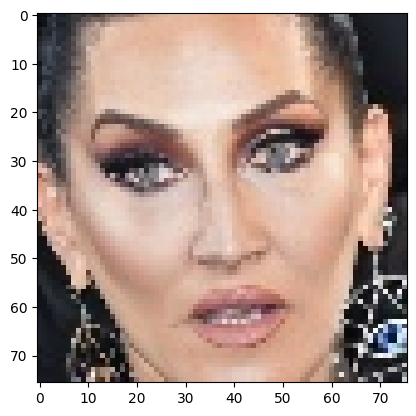

In [11]:
cropped_face=crop_face("Affectnet Dataset/"+data.iloc[0]['pth'])
plt.imshow(cropped_face)

In [9]:
'''def preprocess_image(path,label):
    img = cv2.imread(path)
    cropped_face = crop_face(img)
    resized_face = cv2.resize(cropped_face, (224, 224))
    return resized_face'''

'def preprocess_image(path,label):\n    img = cv2.imread(path)\n    cropped_face = crop_face(img)\n    resized_face = cv2.resize(cropped_face, (224, 224))\n    return resized_face'

In [8]:
lost=0
X_preprocessed=[]
Y_preprocessed=[]

for i in range(0,28176):
    data_dir = "Affectnet Dataset/"+data.iloc[i]['pth']
    #img = cv2.imread(data_dir)
    cropped_face = crop_face(data_dir)
    if cropped_face is not None:
        resized_face = cv2.resize(cropped_face, (224, 224))
        normalised=resized_face/255.0
        X_preprocessed.append(normalised)
        Y_preprocessed.append(y[i])
        print(len(X_preprocessed))
        print(len(Y_preprocessed))

    else:
        lost+=1
        print(lost) 


In [ ]:
import numpy as np
# X_preprocessed = [preprocess_image(path) for path in X]
X_preprocessed = np.array(X_preprocessed)  # Convert to numpy array

In [ ]:
from sklearn.model_selection import train_test_split

# Split the preprocessed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_labels, test_size=0.2, random_state=42, stratify=y_labels)


In [ ]:
import tensorflow as tf

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # Assuming 8 emotion classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


In [ ]:
# Save the model
model.save('models/experimental')
model.save_weights('models/Scaled_model.h5')
